<a href="https://colab.research.google.com/github/pavithkulathunga/AutismoTech/blob/Pavith/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets kaggle


In [10]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od

# Reduce TensorFlow logging
tf.get_logger().setLevel('ERROR')


# Download Dataset

In [3]:
# Authenticate and Download Dataset
od.download("https://www.kaggle.com/datasets/imrankhan77/autistic-children-facial-data-set")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pavithnimantha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/imrankhan77/autistic-children-facial-data-set


100%|██████████| 137M/137M [00:07<00:00, 19.3MB/s]


# Prepare Dataset and Add Some Augmentation


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for the model (MobileNetV2 prefers 224x224)
photo_size = 224

# Batch size
batch_size = 64  # Reduced batch size for better generalization

# Function to prepare dataset
def prepare_dataset(data_dir, validation_split=0.2):
    # Data Augmentation for Training
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=15,  # Reduced to prevent excessive distortion
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,  # Reduced for stability
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode="reflect",
        featurewise_center=True,  # Standardizing input
        featurewise_std_normalization=True,
        validation_split=validation_split  # Ensure split applies to both generators
    )

    # Data Augmentation for Validation (only rescaling)
    val_datagen = ImageDataGenerator(
        rescale=1 / 255,
        validation_split=validation_split
    )

    # Train data generator
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size, photo_size),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
        subset='training'
    )

    # Validation data generator
    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size, photo_size),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
        subset='validation'
    )

    print(f"✅ Loaded {train_generator.samples} training images and {validation_generator.samples} validation images from {data_dir}")
    return train_generator, validation_generator


In [29]:
# Load training dataset (No validation split here)
train_data, _ = prepare_dataset('/content/autistic-children-facial-data-set/train', validation_split=0)

# Load validation dataset separately
val_datagen = ImageDataGenerator(rescale=1 / 255)
validation_data = val_datagen.flow_from_directory(
    '/content/autistic-children-facial-data-set/valid',
    target_size=(photo_size, photo_size),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load test dataset separately
test_datagen = ImageDataGenerator(rescale=1 / 255)
test_data = test_datagen.flow_from_directory(
    '/content/autistic-children-facial-data-set/test',
    target_size=(photo_size, photo_size),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)


Found 2536 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
✅ Loaded 2536 training images and 0 validation images from /content/autistic-children-facial-data-set/train
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# Plot Sample Images

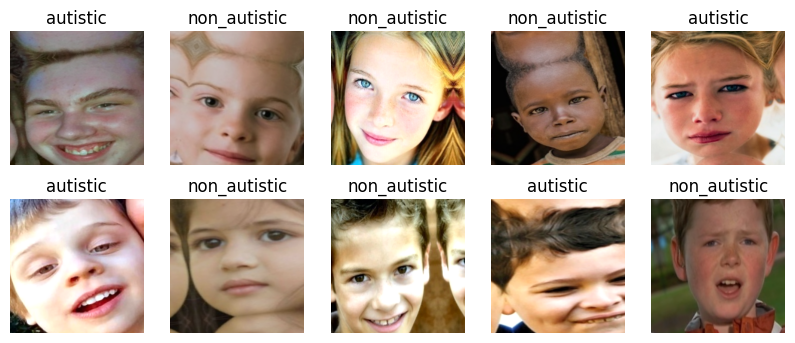

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names from the train generator
class_names = list(train_data.class_indices.keys())

# Extract one batch of images and labels
images, labels = next(train_data)

# Plot 10 sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])  # Convert label to int before indexing
    plt.axis("off")

plt.show()


# Load Pre-Trained Models and Train the Model

In [ ]:
#EfficientNetB0

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Sequential

# Load pre-trained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Converts features to 1D
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 1,679,153 (6.41 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
# Set training parameters
epochs = 10  # 🔹 Increase if needed
batch_size = 32  # 🔹 Ensure it matches the ImageDataGenerator
steps_per_epoch = train_data.samples // batch_size
validation_steps = validation_data.samples // batch_size

# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 653ms/step - accuracy: 0.5049 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 388ms/step - accuracy: 0.4971 - loss: 0.6986 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.5090 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.4981 - loss: 0.6982 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.4847 - loss: 0.6981 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 394ms/step - accuracy: 0.5061 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.4957 - loss: 0.6982 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - accuracy: 0.5031 - loss: 0.6949 - val_accu

In [ ]:
#ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load Pre-trained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze initial layers (to retain pre-trained knowledge)
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Add custom layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification

# Build model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    train_data,
    epochs=30,
    validation_data=validation_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 126s 929ms/step - accuracy: 0.5403 - loss: 0.7335 - val_accuracy: 0.5000 - val_loss: 0.7328
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 438ms/step - accuracy: 0.5860 - loss: 0.6782 - val_accuracy: 0.5000 - val_loss: 0.7157
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 437ms/step - accuracy: 0.5910 - loss: 0.6700 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step - accuracy: 0.6329 - loss: 0.6384 - val_accuracy: 0.5700 - val_loss: 0.6839
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 444ms/step - accuracy: 0.6132 - loss: 0.6633 - val_accuracy: 0.5000 - val_loss: 0.7044
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - accuracy: 0.6239 - loss: 0.6405 - val_accuracy: 0.5000 - val_loss: 0.8353
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 442ms/step - accuracy: 0.6441 - loss: 0.6269 - val_accuracy: 0.5000 - val_loss: 1.0381
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 434

In [32]:
#MobileNetV2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LambdaCallback
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers

# Load MobileNetV2 as a feature extractor
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(photo_size, photo_size, 3))
base_model.trainable = False  # Freeze initial layers

# Function to gradually unfreeze layers
def unfreeze_model(model, num_layers=10):
    for layer in model.layers[-num_layers:]:
        layer.trainable = True

# Build custom classifier
x = GlobalAveragePooling2D()(base_model.output)  # Replaces Flatten for efficiency
x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.4)(x)  # Reduced for better generalization
x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)  # Tweaked optimizer
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Unfreeze layers after 5 epochs
unfreeze_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: unfreeze_model(base_model, 10) if epoch >= 5 else None
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,048,513 (11.63 MB)

 Trainable params: 788,993 (3.01 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [33]:
# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
    callbacks=[lr_scheduler, early_stopping, unfreeze_callback]
)

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_data)
print(f"📊 Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5787 - loss: 1.7892 - val_accuracy: 0.7300 - val_loss: 1.6043 - learning_rate: 3.0000e-04
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 995ms/step - accuracy: 0.7046 - loss: 1.6298 - val_accuracy: 0.7200 - val_loss: 1.5514 - learning_rate: 3.0000e-04
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 897ms/step - accuracy: 0.7226 - loss: 1.5663 - val_accuracy: 0.7600 - val_loss: 1.5056 - learning_rate: 3.0000e-04
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 886ms/step - accuracy: 0.7424 - loss: 1.5204 - val_accuracy: 0.7100 - val_loss: 1.4863 - learning_rate: 3.0000e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 910ms/step - accuracy: 0.7392 - loss: 1.4882 - val_accuracy: 0.7100 - val_loss: 1.5092 - learning_rate: 3.0000e-04
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 861ms/step - accuracy: 0.7548 - loss: 1.4453 - val_accuracy: 0.7000 - val_loss: 1.4663 - learning_rate: 3.0000e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 867ms/step - accura

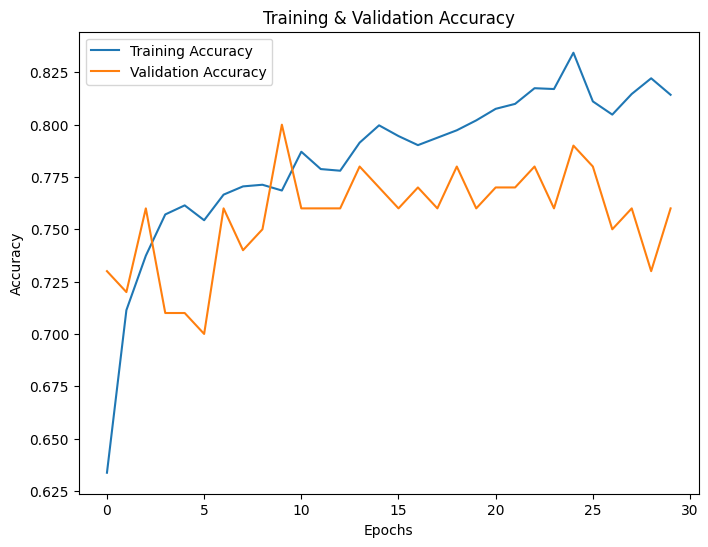

In [35]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 777ms/step


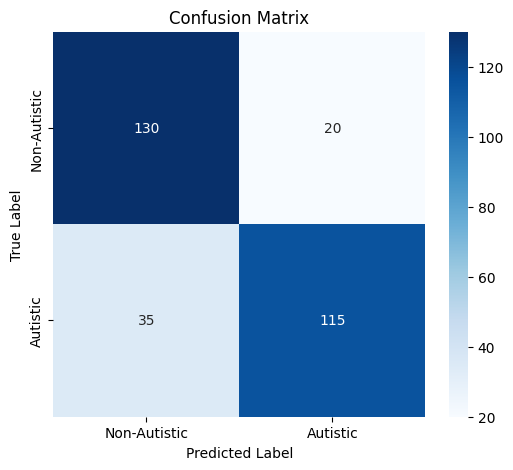

In [36]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = test_data.classes  # True labels
y_pred = (model.predict(test_data) > 0.5).astype("int32")  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Autistic', 'Autistic'], yticklabels=['Non-Autistic', 'Autistic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


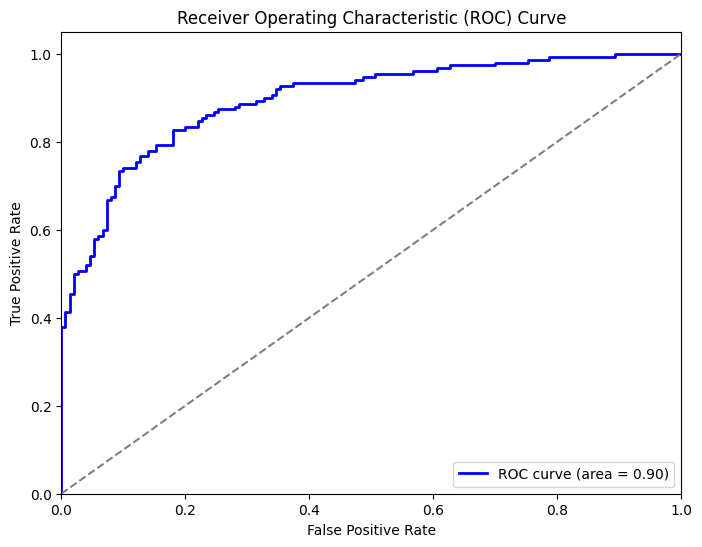

In [37]:
from sklearn.metrics import roc_curve, auc

# Get model predictions (probabilities)
y_probs = model.predict(test_data)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = test_data.classes  # True labels
y_pred = (model.predict(test_data) > 0.5).astype("int32")  # Convert probabilities to binary values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix in list format
print(cm.tolist())  # Convert to list for cleaner output


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
[[130, 20], [35, 115]]


# Save the Model

In [39]:
# Save trained model
model.save("/content/mobilenetv2_final_model.h5")
print("✅ Model saved as 'mobilenetv2_final_model.h5'")

✅ Model saved as 'mobilenetv2_final_model.h5'
